**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
#!pip install 'livelossplot'

**Import libraries**

In [0]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16
from torchvision.models import resnet50


# Tools
import random
import os
import logging
from PIL import Image
#from tqdm import tqdm
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split


# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from livelossplot import PlotLosses


# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/RoboTuan/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

from Caltech101.caltech_dataset import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9291, done.
remote: Total 9291 (delta 0), reused 0 (delta 0), pack-reused 9291
Receiving objects: 100% (9291/9291), 129.49 MiB | 28.39 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (9152/9152), done.


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

#updated from 102 to 101, ask if it's correct
NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
#1e-3
#1e-2
#1e-1
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 40      # Total number of training epochs (iterations over dataset)
#30
#40
STEP_SIZE = 30       # How many epochs before decreasing learning rate (if using a step-down policy)
#10
#20
#30
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
#1
#0.1
#0.01

LOG_FREQUENCY = 10

**Utility Functions**



In [0]:
def plot_accuracy_loss(train_acc, val_acc, train_loss, val_loss, title=None):
  figure, axes = plt.subplots(1, 2, figsize=(10, 5)) 

  axes[0].plot(range(1, NUM_EPOCHS+1), train_loss, label="Train")
  axes[0].plot(range(1, NUM_EPOCHS+1), val_loss, label="Validation")
  axes[0].set_title("Loss")
  axes[0].legend()

  axes[1].plot(range(1, NUM_EPOCHS+1), train_acc,  label="Train")
  axes[1].plot(range(1, NUM_EPOCHS+1), val_acc,  label="Validation")
  axes[1].set_title("Accuracy")
  axes[1].legend()

  if title != None:
    figure.savefig(title + ".png")

  plt.show()

In [0]:
def loadCaltech101(train_transform, eval_transform):
  # Prepare Pytorch train/test Datasets
  train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
  test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


  train_len = int(train_dataset.__len__() * 0.5)
  val_len = int(train_dataset.__len__() * 0.5)

  train_indexes = np.arange(train_dataset.__len__())
  train_labels = np.empty(train_dataset.__len__(), dtype=int)
  for index in train_indexes:
    train_labels[index] = train_dataset.__getitem__(index)[1]


  train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


  # #train_indexes, val_indexes = torch.utils.data.random_split(train_dataset, [train_len, val_len])

  #train_indexes, val_indexes = torch.utils.data.random_split(list(i for i in range(train_dataset.__len__())),[train_len, val_len])

  # #train_indexes = # split the indices for your train split
  # #val_indexes = # split the indices for your val split

  val_dataset = Subset(train_dataset, val_indexes)
  train_dataset = Subset(train_dataset, train_indexes)

  # Check dataset sizes
  print('Train Dataset: {}'.format(len(train_dataset)))
  print('Valid Dataset: {}'.format(len(val_dataset)))
  print('Train + Valid dataset: {}'.format(len(train_dataset) + len(val_dataset)))
  print('Test Dataset: {}'.format(len(test_dataset)))

  return train_dataset, train_indexes, val_dataset, val_indexes, test_dataset


**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [0]:
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)

Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


In [0]:
train_classes = np.zeros(101)

for elem in train_dataset:
  train_classes[elem[1]] += 1

val_classes = np.zeros(101)

for elem in val_dataset:
  val_classes[elem[1]] += 1

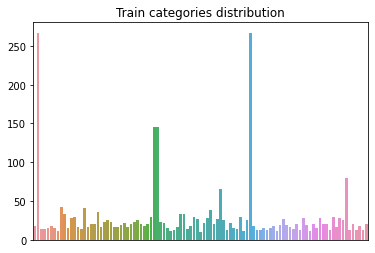

In [0]:
#print(train_classes)
#current_palette = sns.color_palette("colorblind")
ax = sns.barplot(x=np.linspace(0, 100, num=101), y=train_classes)
ax.set_xticks([])
ax.set_title("Train categories distribution")
plt.savefig("train_cat.png")
plt.show()

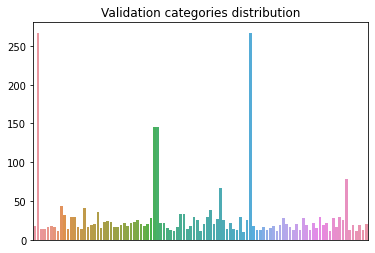

In [0]:
#print(val_classes)
ax = sns.barplot(x=np.linspace(0, 100, num=101), y=val_classes)
ax.set_xticks([])
ax.set_title("Validation categories distribution")
plt.savefig("val_cat.png")
plt.show()

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [0]:
def validation(network):
  #net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  network.train(False) # Set Network to evaluation mode

  running_corrects = 0
  with torch.no_grad(): ## AGGIUNTO PER EVITARE CUDA OUT OF MEMORY ERROR, VEDERE SE VA BENE
    for images, labels in tqdm(val_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = network(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))
  print()
  return accuracy, loss

**Train**

In [0]:
def train(network):
  # By default, everything is loaded to cpu
  network = network.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0

  train_loss = []
  train_accuracy = []
  val_loss = []
  val_accuracy = []

  # Start iterating over the epochs
  # Check if it is correct get_last_lr() or get_lr() (this generates a warning)
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    running_corrects = 0.0
    running_loss = 0.0

    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      #print(labels)
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      network.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = network(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
      running_loss += loss.item() * images.size(0)
      
      current_step += 1

    train_loss.append(running_loss / float(len(train_dataset)))
    train_accuracy.append(running_corrects / float(len(train_dataset)))

    val_acc_loss = validation(network)
    print(val_acc_loss)
    val_accuracy.append(val_acc_loss[0])
    val_loss.append(val_acc_loss[1])

    # Step the scheduler
    scheduler.step() 

  return  train_loss, val_loss, train_accuracy, val_accuracy


In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(net)

Starting epoch 1/40, LR = [0.01]
Step 0, Loss 4.615743637084961
Step 10, Loss 4.600593566894531



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.5959, device='cuda:0'))
Starting epoch 2/40, LR = [0.01]
Step 20, Loss 4.5734333992004395



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.5636, device='cuda:0'))
Starting epoch 3/40, LR = [0.01]
Step 30, Loss 4.538956165313721



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.5037, device='cuda:0'))
Starting epoch 4/40, LR = [0.01]
Step 40, Loss 4.305366039276123



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.1447, device='cuda:0'))
Starting epoch 5/40, LR = [0.01]
Step 50, Loss 4.245182514190674



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.0975, device='cuda:0'))
Starting epoch 6/40, LR = [0.01]
Step 60, Loss 4.248786449432373



Validation Accuracy: 0.09232365145228216

(0.09232365145228216, tensor(4.0675, device='cuda:0'))
Starting epoch 7/40, LR = [0.01]
Step 70, Loss 4.181269645690918



Validation Accuracy: 0.1275933609958506

(0.1275933609958506, tensor(4.0275, device='cuda:0'))
Starting epoch 8/40, LR = [0.01]
Step 80, Loss 4.157266616821289



Validation Accuracy: 0.12932226832641772

(0.12932226832641772, tensor(4.0212, device='cuda:0'))
Starting epoch 9/40, LR = [0.01]
Step 90, Loss 4.010012626647949



Validation Accuracy: 0.19432918395573998

(0.19432918395573998, tensor(3.9569, device='cuda:0'))
Starting epoch 10/40, LR = [0.01]
Step 100, Loss 3.9450175762176514



Validation Accuracy: 0.19363762102351315

(0.19363762102351315, tensor(3.8222, device='cuda:0'))
Starting epoch 11/40, LR = [0.01]
Step 110, Loss 4.058934688568115
Step 120, Loss 3.789440631866455



Validation Accuracy: 0.20781466113416322

(0.20781466113416322, tensor(3.6201, device='cuda:0'))
Starting epoch 12/40, LR = [0.01]
Step 130, Loss 3.865224838256836



Validation Accuracy: 0.21265560165975103

(0.21265560165975103, tensor(3.4755, device='cuda:0'))
Starting epoch 13/40, LR = [0.01]
Step 140, Loss 3.7879111766815186



Validation Accuracy: 0.18706777316735823

(0.18706777316735823, tensor(4.0920, device='cuda:0'))
Starting epoch 14/40, LR = [0.01]
Step 150, Loss 3.627171754837036



Validation Accuracy: 0.23443983402489627

(0.23443983402489627, tensor(3.3747, device='cuda:0'))
Starting epoch 15/40, LR = [0.01]
Step 160, Loss 3.6737773418426514



Validation Accuracy: 0.23962655601659752

(0.23962655601659752, tensor(3.2425, device='cuda:0'))
Starting epoch 16/40, LR = [0.01]
Step 170, Loss 3.495478868484497



Validation Accuracy: 0.2389349930843707

(0.2389349930843707, tensor(3.2557, device='cuda:0'))
Starting epoch 17/40, LR = [0.01]
Step 180, Loss 3.333054542541504



Validation Accuracy: 0.25

(0.25, tensor(3.1636, device='cuda:0'))
Starting epoch 18/40, LR = [0.01]
Step 190, Loss 3.2188916206359863



Validation Accuracy: 0.25380359612724757

(0.25380359612724757, tensor(3.4667, device='cuda:0'))
Starting epoch 19/40, LR = [0.01]
Step 200, Loss 4.154018402099609



Validation Accuracy: 0.26383125864453666

(0.26383125864453666, tensor(3.1651, device='cuda:0'))
Starting epoch 20/40, LR = [0.01]
Step 210, Loss 3.230093240737915



Validation Accuracy: 0.2773167358229599

(0.2773167358229599, tensor(3.1490, device='cuda:0'))
Starting epoch 21/40, LR = [0.01]
Step 220, Loss 3.3018784523010254
Step 230, Loss 3.038731098175049



Validation Accuracy: 0.29114799446749656

(0.29114799446749656, tensor(2.9825, device='cuda:0'))
Starting epoch 22/40, LR = [0.01]
Step 240, Loss 3.3708877563476562



Validation Accuracy: 0.3087828492392808

(0.3087828492392808, tensor(3.0410, device='cuda:0'))
Starting epoch 23/40, LR = [0.01]
Step 250, Loss 3.0143935680389404



Validation Accuracy: 0.3087828492392808

(0.3087828492392808, tensor(2.9688, device='cuda:0'))
Starting epoch 24/40, LR = [0.01]
Step 260, Loss 2.8106446266174316



Validation Accuracy: 0.24827109266943292

(0.24827109266943292, tensor(3.4392, device='cuda:0'))
Starting epoch 25/40, LR = [0.01]
Step 270, Loss 2.967780113220215



Validation Accuracy: 0.3243430152143845

(0.3243430152143845, tensor(2.9172, device='cuda:0'))
Starting epoch 26/40, LR = [0.01]
Step 280, Loss 3.0370633602142334



Validation Accuracy: 0.3426694329183956

(0.3426694329183956, tensor(2.6918, device='cuda:0'))
Starting epoch 27/40, LR = [0.01]
Step 290, Loss 3.6714532375335693



Validation Accuracy: 0.32503457814661135

(0.32503457814661135, tensor(2.8629, device='cuda:0'))
Starting epoch 28/40, LR = [0.01]
Step 300, Loss 2.6014721393585205



Validation Accuracy: 0.36410788381742737

(0.36410788381742737, tensor(2.6187, device='cuda:0'))
Starting epoch 29/40, LR = [0.01]
Step 310, Loss 2.6141490936279297



Validation Accuracy: 0.37655601659751037

(0.37655601659751037, tensor(2.6911, device='cuda:0'))
Starting epoch 30/40, LR = [0.01]
Step 320, Loss 2.227506637573242



Validation Accuracy: 0.40110650069156295

(0.40110650069156295, tensor(2.4988, device='cuda:0'))
Starting epoch 31/40, LR = [0.001]
Step 330, Loss 2.1044342517852783
Step 340, Loss 2.1428136825561523



Validation Accuracy: 0.4139004149377593

(0.4139004149377593, tensor(2.4152, device='cuda:0'))
Starting epoch 32/40, LR = [0.001]
Step 350, Loss 2.0520496368408203



Validation Accuracy: 0.4166666666666667

(0.4166666666666667, tensor(2.3719, device='cuda:0'))
Starting epoch 33/40, LR = [0.001]
Step 360, Loss 2.231218099594116



Validation Accuracy: 0.4173582295988935

(0.4173582295988935, tensor(2.3648, device='cuda:0'))
Starting epoch 34/40, LR = [0.001]
Step 370, Loss 1.890992522239685



Validation Accuracy: 0.4190871369294606

(0.4190871369294606, tensor(2.3638, device='cuda:0'))
Starting epoch 35/40, LR = [0.001]
Step 380, Loss 2.0472569465637207



Validation Accuracy: 0.4211618257261411

(0.4211618257261411, tensor(2.3356, device='cuda:0'))
Starting epoch 36/40, LR = [0.001]
Step 390, Loss 2.0506255626678467



Validation Accuracy: 0.4215076071922545

(0.4215076071922545, tensor(2.3501, device='cuda:0'))
Starting epoch 37/40, LR = [0.001]
Step 400, Loss 2.009269952774048



Validation Accuracy: 0.4266943291839557

(0.4266943291839557, tensor(2.3261, device='cuda:0'))
Starting epoch 38/40, LR = [0.001]
Step 410, Loss 1.883876085281372



Validation Accuracy: 0.42911479944674963

(0.42911479944674963, tensor(2.3311, device='cuda:0'))
Starting epoch 39/40, LR = [0.001]
Step 420, Loss 1.9974024295806885



Validation Accuracy: 0.42773167358229597

(0.42773167358229597, tensor(2.3072, device='cuda:0'))
Starting epoch 40/40, LR = [0.001]
Step 430, Loss 1.8061367273330688



Validation Accuracy: 0.42946058091286304

(0.42946058091286304, tensor(2.3200, device='cuda:0'))


**Test**

In [0]:
 def testing(network):
  network = network.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  network.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = network(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))

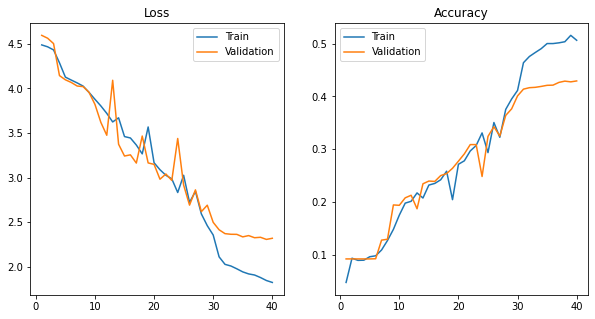


Test Accuracy: 0.4376080193570688


In [0]:
#validation(net)
#len(val_dataloader)
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="scratch_ep40_lr1e-2_steps30")
testing(net)

**Transfer Learning** 

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 

BATCH_SIZE = 512 #If I change this, I need to reload the Dataloaders!!!
#256

LR = 1e-2 

MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-3  

NUM_EPOCHS = 30
#30
#20
#15      
STEP_SIZE = 20
#20
#10
#5      
GAMMA = 0.1         

LOG_FREQUENCY = 10

**Preprocessing for transfer learning** 

In [0]:
# Normalization for Imagenet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      normalize # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize                                    
])

In [0]:
# Get datasets and indeces
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)


# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


**Train the whole pre-trained network**

In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.8410258293151855



Validation Accuracy: 0.4661134163208852

(0.4661134163208852, tensor(2.3740, device='cuda:0'))
Starting epoch 2/30, LR = [0.01]



Validation Accuracy: 0.691908713692946

(0.691908713692946, tensor(1.1633, device='cuda:0'))
Starting epoch 3/30, LR = [0.01]
Step 10, Loss 0.8962904810905457



Validation Accuracy: 0.7939142461964038

(0.7939142461964038, tensor(0.8150, device='cuda:0'))
Starting epoch 4/30, LR = [0.01]



Validation Accuracy: 0.8077455048409405

(0.8077455048409405, tensor(0.7889, device='cuda:0'))
Starting epoch 5/30, LR = [0.01]
Step 20, Loss 0.21336421370506287



Validation Accuracy: 0.8191562932226832

(0.8191562932226832, tensor(0.8028, device='cuda:0'))
Starting epoch 6/30, LR = [0.01]



Validation Accuracy: 0.8236514522821576

(0.8236514522821576, tensor(0.7840, device='cuda:0'))
Starting epoch 7/30, LR = [0.01]
Step 30, Loss 0.03728720545768738



Validation Accuracy: 0.8233056708160442

(0.8233056708160442, tensor(0.8206, device='cuda:0'))
Starting epoch 8/30, LR = [0.01]



Validation Accuracy: 0.8212309820193637

(0.8212309820193637, tensor(0.8680, device='cuda:0'))
Starting epoch 9/30, LR = [0.01]
Step 40, Loss 0.02565024420619011



Validation Accuracy: 0.8236514522821576

(0.8236514522821576, tensor(0.7958, device='cuda:0'))
Starting epoch 10/30, LR = [0.01]



Validation Accuracy: 0.8274550484094052

(0.8274550484094052, tensor(0.8000, device='cuda:0'))
Starting epoch 11/30, LR = [0.01]
Step 50, Loss 0.010791974142193794



Validation Accuracy: 0.8336791147994468

(0.8336791147994468, tensor(0.8113, device='cuda:0'))
Starting epoch 12/30, LR = [0.01]



Validation Accuracy: 0.8284923928077456

(0.8284923928077456, tensor(0.8129, device='cuda:0'))
Starting epoch 13/30, LR = [0.01]
Step 60, Loss 0.005922550335526466



Validation Accuracy: 0.8312586445366529

(0.8312586445366529, tensor(0.7913, device='cuda:0'))
Starting epoch 14/30, LR = [0.01]



Validation Accuracy: 0.83298755186722

(0.83298755186722, tensor(0.8115, device='cuda:0'))
Starting epoch 15/30, LR = [0.01]
Step 70, Loss 0.008889410644769669



Validation Accuracy: 0.8343706777316736

(0.8343706777316736, tensor(0.8279, device='cuda:0'))
Starting epoch 16/30, LR = [0.01]



Validation Accuracy: 0.8298755186721992

(0.8298755186721992, tensor(0.8430, device='cuda:0'))
Starting epoch 17/30, LR = [0.01]
Step 80, Loss 0.011084271594882011



Validation Accuracy: 0.8295297372060858

(0.8295297372060858, tensor(0.8207, device='cuda:0'))
Starting epoch 18/30, LR = [0.01]



Validation Accuracy: 0.8274550484094052

(0.8274550484094052, tensor(0.7947, device='cuda:0'))
Starting epoch 19/30, LR = [0.01]
Step 90, Loss 0.010642223060131073



Validation Accuracy: 0.8350622406639004

(0.8350622406639004, tensor(0.7646, device='cuda:0'))
Starting epoch 20/30, LR = [0.01]



Validation Accuracy: 0.830567081604426

(0.830567081604426, tensor(0.7895, device='cuda:0'))
Starting epoch 21/30, LR = [0.001]
Step 100, Loss 0.007673323154449463



Validation Accuracy: 0.8336791147994468

(0.8336791147994468, tensor(0.7864, device='cuda:0'))
Starting epoch 22/30, LR = [0.001]



Validation Accuracy: 0.8326417704011065

(0.8326417704011065, tensor(0.7807, device='cuda:0'))
Starting epoch 23/30, LR = [0.001]
Step 110, Loss 0.004692679271101952



Validation Accuracy: 0.8354080221300139

(0.8354080221300139, tensor(0.7779, device='cuda:0'))
Starting epoch 24/30, LR = [0.001]



Validation Accuracy: 0.8350622406639004

(0.8350622406639004, tensor(0.7751, device='cuda:0'))
Starting epoch 25/30, LR = [0.001]
Step 120, Loss 0.004504293203353882



Validation Accuracy: 0.8326417704011065

(0.8326417704011065, tensor(0.7751, device='cuda:0'))
Starting epoch 26/30, LR = [0.001]



Validation Accuracy: 0.83298755186722

(0.83298755186722, tensor(0.7771, device='cuda:0'))
Starting epoch 27/30, LR = [0.001]
Step 130, Loss 0.0035985447466373444



Validation Accuracy: 0.83298755186722

(0.83298755186722, tensor(0.7756, device='cuda:0'))
Starting epoch 28/30, LR = [0.001]



Validation Accuracy: 0.8350622406639004

(0.8350622406639004, tensor(0.7725, device='cuda:0'))
Starting epoch 29/30, LR = [0.001]
Step 140, Loss 0.004535680636763573



Validation Accuracy: 0.8343706777316736

(0.8343706777316736, tensor(0.7711, device='cuda:0'))
Starting epoch 30/30, LR = [0.001]



Validation Accuracy: 0.8343706777316736

(0.8343706777316736, tensor(0.7715, device='cuda:0'))


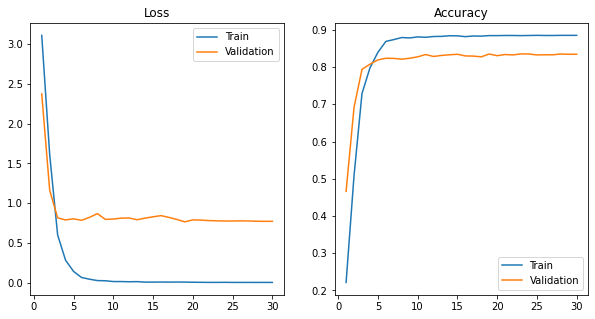


Test Accuracy: 0.8520566885585897


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="trained_ep30_lr1e-2_steps20_batch512_wd5e-3")
testing(pre_net)

**Train only the fully connected layers**

In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Freeze convolutional layers
for param in pre_net.features.parameters():
    param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.8839945793151855



Validation Accuracy: 0.487551867219917

(0.487551867219917, tensor(2.2161, device='cuda:0'))
Starting epoch 2/30, LR = [0.01]



Validation Accuracy: 0.6912171507607192

(0.6912171507607192, tensor(1.2797, device='cuda:0'))
Starting epoch 3/30, LR = [0.01]
Step 10, Loss 1.1737643480300903



Validation Accuracy: 0.7762793914246197

(0.7762793914246197, tensor(0.9182, device='cuda:0'))
Starting epoch 4/30, LR = [0.01]



Validation Accuracy: 0.803941908713693

(0.803941908713693, tensor(0.7562, device='cuda:0'))
Starting epoch 5/30, LR = [0.01]
Step 20, Loss 0.3540635108947754



Validation Accuracy: 0.809820193637621

(0.809820193637621, tensor(0.6942, device='cuda:0'))
Starting epoch 6/30, LR = [0.01]



Validation Accuracy: 0.8170816044260027

(0.8170816044260027, tensor(0.6576, device='cuda:0'))
Starting epoch 7/30, LR = [0.01]
Step 30, Loss 0.17211592197418213



Validation Accuracy: 0.8177731673582296

(0.8177731673582296, tensor(0.6511, device='cuda:0'))
Starting epoch 8/30, LR = [0.01]



Validation Accuracy: 0.8257261410788381

(0.8257261410788381, tensor(0.6406, device='cuda:0'))
Starting epoch 9/30, LR = [0.01]
Step 40, Loss 0.08362473547458649



Validation Accuracy: 0.8201936376210235

(0.8201936376210235, tensor(0.6594, device='cuda:0'))
Starting epoch 10/30, LR = [0.01]



Validation Accuracy: 0.8267634854771784

(0.8267634854771784, tensor(0.6410, device='cuda:0'))
Starting epoch 11/30, LR = [0.01]
Step 50, Loss 0.052523307502269745



Validation Accuracy: 0.8284923928077456

(0.8284923928077456, tensor(0.6376, device='cuda:0'))
Starting epoch 12/30, LR = [0.01]



Validation Accuracy: 0.826417704011065

(0.826417704011065, tensor(0.6346, device='cuda:0'))
Starting epoch 13/30, LR = [0.01]
Step 60, Loss 0.03989554941654205



Validation Accuracy: 0.8236514522821576

(0.8236514522821576, tensor(0.6314, device='cuda:0'))
Starting epoch 14/30, LR = [0.01]



Validation Accuracy: 0.8253803596127247

(0.8253803596127247, tensor(0.6304, device='cuda:0'))
Starting epoch 15/30, LR = [0.01]
Step 70, Loss 0.04503681883215904



Validation Accuracy: 0.8278008298755186

(0.8278008298755186, tensor(0.6309, device='cuda:0'))
Starting epoch 16/30, LR = [0.01]



Validation Accuracy: 0.8302213001383126

(0.8302213001383126, tensor(0.6296, device='cuda:0'))
Starting epoch 17/30, LR = [0.01]
Step 80, Loss 0.040938857942819595



Validation Accuracy: 0.828838174273859

(0.828838174273859, tensor(0.6279, device='cuda:0'))
Starting epoch 18/30, LR = [0.01]



Validation Accuracy: 0.8229598893499308

(0.8229598893499308, tensor(0.6360, device='cuda:0'))
Starting epoch 19/30, LR = [0.01]
Step 90, Loss 0.025899920612573624



Validation Accuracy: 0.83298755186722

(0.83298755186722, tensor(0.6250, device='cuda:0'))
Starting epoch 20/30, LR = [0.01]



Validation Accuracy: 0.8343706777316736

(0.8343706777316736, tensor(0.6258, device='cuda:0'))
Starting epoch 21/30, LR = [0.001]
Step 100, Loss 0.025509029626846313



Validation Accuracy: 0.8343706777316736

(0.8343706777316736, tensor(0.6257, device='cuda:0'))
Starting epoch 22/30, LR = [0.001]



Validation Accuracy: 0.8343706777316736

(0.8343706777316736, tensor(0.6251, device='cuda:0'))
Starting epoch 23/30, LR = [0.001]
Step 110, Loss 0.029122568666934967



Validation Accuracy: 0.834716459197787

(0.834716459197787, tensor(0.6259, device='cuda:0'))
Starting epoch 24/30, LR = [0.001]



Validation Accuracy: 0.8333333333333334

(0.8333333333333334, tensor(0.6257, device='cuda:0'))
Starting epoch 25/30, LR = [0.001]
Step 120, Loss 0.0266035795211792



Validation Accuracy: 0.8336791147994468

(0.8336791147994468, tensor(0.6251, device='cuda:0'))
Starting epoch 26/30, LR = [0.001]



Validation Accuracy: 0.8333333333333334

(0.8333333333333334, tensor(0.6243, device='cuda:0'))
Starting epoch 27/30, LR = [0.001]
Step 130, Loss 0.02681739442050457



Validation Accuracy: 0.8326417704011065

(0.8326417704011065, tensor(0.6223, device='cuda:0'))
Starting epoch 28/30, LR = [0.001]



Validation Accuracy: 0.8333333333333334

(0.8333333333333334, tensor(0.6214, device='cuda:0'))
Starting epoch 29/30, LR = [0.001]
Step 140, Loss 0.02040012925863266



Validation Accuracy: 0.8326417704011065

(0.8326417704011065, tensor(0.6216, device='cuda:0'))
Starting epoch 30/30, LR = [0.001]



Validation Accuracy: 0.83298755186722

(0.83298755186722, tensor(0.6219, device='cuda:0'))


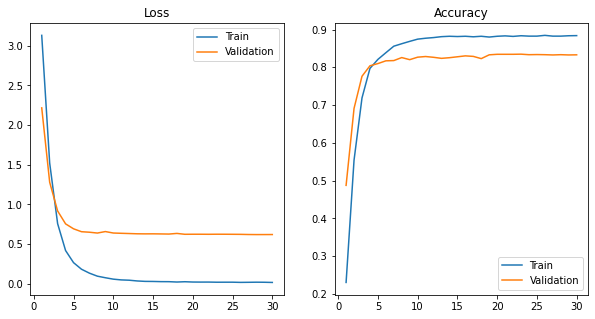


Test Accuracy: 0.8520566885585897


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="trained_only_FC_layers")
testing(pre_net)

**Train only the convolutional layers**

In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Freeze fully connected layers
for param in pre_net.classifier.parameters():
  param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_list = list(pre_net.features.parameters()) + list(pre_net.classifier[6].parameters())
parameters_to_optimize = (par for par in parameters_list)

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.853344917297363



Validation Accuracy: 0.4429460580912863

(0.4429460580912863, tensor(2.4006, device='cuda:0'))
Starting epoch 2/30, LR = [0.01]



Validation Accuracy: 0.6410788381742739

(0.6410788381742739, tensor(1.4805, device='cuda:0'))
Starting epoch 3/30, LR = [0.01]
Step 10, Loss 1.23650062084198



Validation Accuracy: 0.7821576763485477

(0.7821576763485477, tensor(0.8151, device='cuda:0'))
Starting epoch 4/30, LR = [0.01]



Validation Accuracy: 0.8077455048409405

(0.8077455048409405, tensor(0.7781, device='cuda:0'))
Starting epoch 5/30, LR = [0.01]
Step 20, Loss 0.1950054168701172



Validation Accuracy: 0.8250345781466113

(0.8250345781466113, tensor(0.7320, device='cuda:0'))
Starting epoch 6/30, LR = [0.01]



Validation Accuracy: 0.8267634854771784

(0.8267634854771784, tensor(0.7272, device='cuda:0'))
Starting epoch 7/30, LR = [0.01]
Step 30, Loss 0.05210985243320465



Validation Accuracy: 0.822268326417704

(0.822268326417704, tensor(0.7628, device='cuda:0'))
Starting epoch 8/30, LR = [0.01]



Validation Accuracy: 0.8257261410788381

(0.8257261410788381, tensor(0.7616, device='cuda:0'))
Starting epoch 9/30, LR = [0.01]
Step 40, Loss 0.05330329388380051



Validation Accuracy: 0.8309128630705395

(0.8309128630705395, tensor(0.7572, device='cuda:0'))
Starting epoch 10/30, LR = [0.01]



Validation Accuracy: 0.8319502074688797

(0.8319502074688797, tensor(0.8104, device='cuda:0'))
Starting epoch 11/30, LR = [0.01]
Step 50, Loss 0.025734396651387215



Validation Accuracy: 0.8298755186721992

(0.8298755186721992, tensor(0.7974, device='cuda:0'))
Starting epoch 12/30, LR = [0.01]



Validation Accuracy: 0.830567081604426

(0.830567081604426, tensor(0.7667, device='cuda:0'))
Starting epoch 13/30, LR = [0.01]
Step 60, Loss 0.014927094802260399



Validation Accuracy: 0.830567081604426

(0.830567081604426, tensor(0.7600, device='cuda:0'))
Starting epoch 14/30, LR = [0.01]



Validation Accuracy: 0.8319502074688797

(0.8319502074688797, tensor(0.7446, device='cuda:0'))
Starting epoch 15/30, LR = [0.01]
Step 70, Loss 0.006919758394360542



Validation Accuracy: 0.8381742738589212

(0.8381742738589212, tensor(0.7479, device='cuda:0'))
Starting epoch 16/30, LR = [0.01]



Validation Accuracy: 0.8350622406639004

(0.8350622406639004, tensor(0.8049, device='cuda:0'))
Starting epoch 17/30, LR = [0.01]
Step 80, Loss 0.016685105860233307



Validation Accuracy: 0.8322959889349931

(0.8322959889349931, tensor(0.7606, device='cuda:0'))
Starting epoch 18/30, LR = [0.01]



Validation Accuracy: 0.8319502074688797

(0.8319502074688797, tensor(0.7722, device='cuda:0'))
Starting epoch 19/30, LR = [0.01]
Step 90, Loss 0.01601894199848175



Validation Accuracy: 0.8333333333333334

(0.8333333333333334, tensor(0.7483, device='cuda:0'))
Starting epoch 20/30, LR = [0.01]



Validation Accuracy: 0.8360995850622407

(0.8360995850622407, tensor(0.7305, device='cuda:0'))
Starting epoch 21/30, LR = [0.001]
Step 100, Loss 0.0074188001453876495



Validation Accuracy: 0.8354080221300139

(0.8354080221300139, tensor(0.7265, device='cuda:0'))
Starting epoch 22/30, LR = [0.001]



Validation Accuracy: 0.8364453665283541

(0.8364453665283541, tensor(0.7225, device='cuda:0'))
Starting epoch 23/30, LR = [0.001]
Step 110, Loss 0.007742920890450478



Validation Accuracy: 0.8364453665283541

(0.8364453665283541, tensor(0.7190, device='cuda:0'))
Starting epoch 24/30, LR = [0.001]



Validation Accuracy: 0.8392116182572614

(0.8392116182572614, tensor(0.7163, device='cuda:0'))
Starting epoch 25/30, LR = [0.001]
Step 120, Loss 0.005563206970691681



Validation Accuracy: 0.8416320885200553

(0.8416320885200553, tensor(0.7154, device='cuda:0'))
Starting epoch 26/30, LR = [0.001]



Validation Accuracy: 0.8416320885200553

(0.8416320885200553, tensor(0.7168, device='cuda:0'))
Starting epoch 27/30, LR = [0.001]
Step 130, Loss 0.0032897554337978363



Validation Accuracy: 0.8399031811894883

(0.8399031811894883, tensor(0.7203, device='cuda:0'))
Starting epoch 28/30, LR = [0.001]



Validation Accuracy: 0.8395573997233748

(0.8395573997233748, tensor(0.7237, device='cuda:0'))
Starting epoch 29/30, LR = [0.001]
Step 140, Loss 0.009450884535908699



Validation Accuracy: 0.8412863070539419

(0.8412863070539419, tensor(0.7272, device='cuda:0'))
Starting epoch 30/30, LR = [0.001]



Validation Accuracy: 0.8416320885200553

(0.8416320885200553, tensor(0.7301, device='cuda:0'))


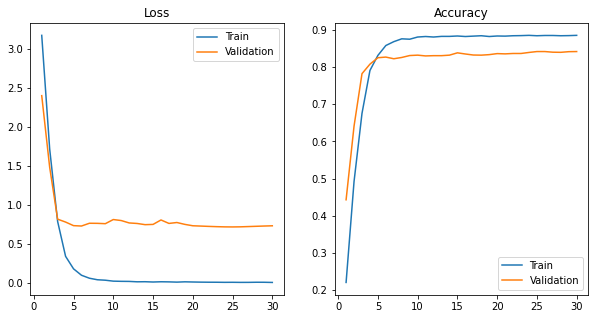


Test Accuracy: 0.8385758727964051


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="trained_only_Conv_layers")
testing(pre_net)

**Data Augmentation**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 

BATCH_SIZE = 512 #If I change this, I need to reload the Dataloaders!!!

LR = 1e-2 

MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-3  

NUM_EPOCHS = 30      
STEP_SIZE = 20
#10
#5      
GAMMA = 0.1         

LOG_FREQUENCY = 10

**Preprocessing for Data Augmentation**

In [0]:
# Normalization for Imagenet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.1),
                                      #transforms.RandomRotation(degrees=45),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.3, hue=0.1),
                                      #transforms.RandomGrayscale(1),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      normalize # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase 
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize                                    
])

In [0]:
# Get datasets and indeces
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)


# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Freeze layers
for param in pre_net.features.parameters():
    param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#pre_net.eval()

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.932139873504639



Validation Accuracy: 0.40283540802213

(0.40283540802213, tensor(2.6096, device='cuda:0'))
Starting epoch 2/30, LR = [0.01]



Validation Accuracy: 0.6061549100968188

(0.6061549100968188, tensor(1.6098, device='cuda:0'))
Starting epoch 3/30, LR = [0.01]
Step 10, Loss 1.5940866470336914



Validation Accuracy: 0.6877593360995851

(0.6877593360995851, tensor(1.2081, device='cuda:0'))
Starting epoch 4/30, LR = [0.01]



Validation Accuracy: 0.7306362378976486

(0.7306362378976486, tensor(1.0550, device='cuda:0'))
Starting epoch 5/30, LR = [0.01]
Step 20, Loss 0.7623976469039917



Validation Accuracy: 0.7451590594744122

(0.7451590594744122, tensor(0.9507, device='cuda:0'))
Starting epoch 6/30, LR = [0.01]



Validation Accuracy: 0.7721300138312587

(0.7721300138312587, tensor(0.7813, device='cuda:0'))
Starting epoch 7/30, LR = [0.01]
Step 30, Loss 0.5000390410423279



Validation Accuracy: 0.7735131396957123

(0.7735131396957123, tensor(0.8350, device='cuda:0'))
Starting epoch 8/30, LR = [0.01]



Validation Accuracy: 0.7714384508990318

(0.7714384508990318, tensor(0.7692, device='cuda:0'))
Starting epoch 9/30, LR = [0.01]
Step 40, Loss 0.48682084679603577



Validation Accuracy: 0.7911479944674965

(0.7911479944674965, tensor(0.8036, device='cuda:0'))
Starting epoch 10/30, LR = [0.01]



Validation Accuracy: 0.7845781466113416

(0.7845781466113416, tensor(0.7659, device='cuda:0'))
Starting epoch 11/30, LR = [0.01]
Step 50, Loss 0.3112323582172394



Validation Accuracy: 0.7828492392807745

(0.7828492392807745, tensor(0.8213, device='cuda:0'))
Starting epoch 12/30, LR = [0.01]



Validation Accuracy: 0.7852697095435685

(0.7852697095435685, tensor(0.7738, device='cuda:0'))
Starting epoch 13/30, LR = [0.01]
Step 60, Loss 0.2796907126903534



Validation Accuracy: 0.7825034578146611

(0.7825034578146611, tensor(0.8288, device='cuda:0'))
Starting epoch 14/30, LR = [0.01]



Validation Accuracy: 0.7838865836791148

(0.7838865836791148, tensor(0.8215, device='cuda:0'))
Starting epoch 15/30, LR = [0.01]
Step 70, Loss 0.2614988088607788



Validation Accuracy: 0.7914937759336099

(0.7914937759336099, tensor(0.7407, device='cuda:0'))
Starting epoch 16/30, LR = [0.01]



Validation Accuracy: 0.7887275242047026

(0.7887275242047026, tensor(0.7406, device='cuda:0'))
Starting epoch 17/30, LR = [0.01]
Step 80, Loss 0.23142501711845398



Validation Accuracy: 0.7970262793914247

(0.7970262793914247, tensor(0.7570, device='cuda:0'))
Starting epoch 18/30, LR = [0.01]



Validation Accuracy: 0.7873443983402489

(0.7873443983402489, tensor(0.6927, device='cuda:0'))
Starting epoch 19/30, LR = [0.01]
Step 90, Loss 0.24758553504943848



Validation Accuracy: 0.7797372060857538

(0.7797372060857538, tensor(0.7968, device='cuda:0'))
Starting epoch 20/30, LR = [0.01]



Validation Accuracy: 0.7980636237897649

(0.7980636237897649, tensor(0.6995, device='cuda:0'))
Starting epoch 21/30, LR = [0.001]
Step 100, Loss 0.18325643241405487



Validation Accuracy: 0.8022130013831259

(0.8022130013831259, tensor(0.6832, device='cuda:0'))
Starting epoch 22/30, LR = [0.001]



Validation Accuracy: 0.7970262793914247

(0.7970262793914247, tensor(0.7273, device='cuda:0'))
Starting epoch 23/30, LR = [0.001]
Step 110, Loss 0.18786297738552094



Validation Accuracy: 0.8004840940525588

(0.8004840940525588, tensor(0.6505, device='cuda:0'))
Starting epoch 24/30, LR = [0.001]



Validation Accuracy: 0.80567081604426

(0.80567081604426, tensor(0.6909, device='cuda:0'))
Starting epoch 25/30, LR = [0.001]
Step 120, Loss 0.15146228671073914



Validation Accuracy: 0.7942600276625172

(0.7942600276625172, tensor(0.7139, device='cuda:0'))
Starting epoch 26/30, LR = [0.001]



Validation Accuracy: 0.8029045643153527

(0.8029045643153527, tensor(0.7921, device='cuda:0'))
Starting epoch 27/30, LR = [0.001]
Step 130, Loss 0.1808093935251236



Validation Accuracy: 0.793222683264177

(0.793222683264177, tensor(0.7353, device='cuda:0'))
Starting epoch 28/30, LR = [0.001]



Validation Accuracy: 0.80567081604426

(0.80567081604426, tensor(0.7256, device='cuda:0'))
Starting epoch 29/30, LR = [0.001]
Step 140, Loss 0.18063978850841522



Validation Accuracy: 0.7970262793914247

(0.7970262793914247, tensor(0.6908, device='cuda:0'))
Starting epoch 30/30, LR = [0.001]



Validation Accuracy: 0.7977178423236515

(0.7977178423236515, tensor(0.7618, device='cuda:0'))


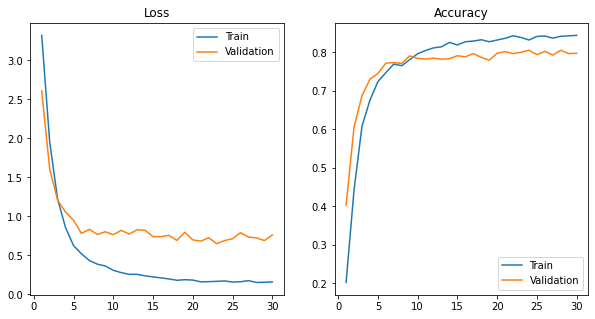


Test Accuracy: 0.8444521258209471


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="hor_vert_jit_hue<sat_30")
testing(pre_net)

**Beyond AlexNet**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 

BATCH_SIZE = 64 #If I change this, I need to reload the Dataloaders!!!
#256

LR = 1e-2 

MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  

NUM_EPOCHS = 15
#30
#20
#15      
STEP_SIZE = 10
#20
#10
#5      
GAMMA = 0.1         

LOG_FREQUENCY = 10

In [0]:
# Normalization for Imagenet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      normalize # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize                                    
])

In [0]:
# Get datasets and indeces
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)


# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


In [0]:
# Load the pre-trained network
pre_net = vgg16(pretrained=True)

# Freeze convolutional layers
for param in pre_net.features.parameters():
    param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.740802764892578
Step 10, Loss 2.658234119415283
Step 20, Loss 1.2932363748550415
Step 30, Loss 0.6631873250007629
Step 40, Loss 0.6882691383361816



Validation Accuracy: 0.8582295988934993

(0.8582295988934993, tensor(0.7925, device='cuda:0'))
Starting epoch 2/15, LR = [0.01]
Step 50, Loss 0.12993717193603516
Step 60, Loss 0.130061537027359
Step 70, Loss 0.11365427076816559
Step 80, Loss 0.11469791829586029



Validation Accuracy: 0.8703319502074689

(0.8703319502074689, tensor(0.5893, device='cuda:0'))
Starting epoch 3/15, LR = [0.01]
Step 90, Loss 0.13480089604854584
Step 100, Loss 0.09441805630922318
Step 110, Loss 0.12486422806978226
Step 120, Loss 0.03428007662296295
Step 130, Loss 0.14679700136184692



Validation Accuracy: 0.8890041493775933

(0.8890041493775933, tensor(0.4604, device='cuda:0'))
Starting epoch 4/15, LR = [0.01]
Step 140, Loss 0.0144101083278656
Step 150, Loss 0.015726730227470398
Step 160, Loss 0.012407951056957245
Step 170, Loss 0.01069881021976471



Validation Accuracy: 0.8941908713692946

(0.8941908713692946, tensor(0.4512, device='cuda:0'))
Starting epoch 5/15, LR = [0.01]
Step 180, Loss 0.00734257698059082
Step 190, Loss 0.01363430917263031
Step 200, Loss 0.006707966327667236
Step 210, Loss 0.026456758379936218
Step 220, Loss 0.039225488901138306



Validation Accuracy: 0.886237897648686

(0.886237897648686, tensor(0.4313, device='cuda:0'))
Starting epoch 6/15, LR = [0.01]
Step 230, Loss 0.004144489765167236
Step 240, Loss 0.003842264413833618
Step 250, Loss 0.0037881135940551758
Step 260, Loss 0.048288069665431976



Validation Accuracy: 0.8924619640387276

(0.8924619640387276, tensor(0.5005, device='cuda:0'))
Starting epoch 7/15, LR = [0.01]
Step 270, Loss 0.004152804613113403
Step 280, Loss 0.005994275212287903
Step 290, Loss 0.006468623876571655
Step 300, Loss 0.07140927761793137
Step 310, Loss 0.006266191601753235



Validation Accuracy: 0.8948824343015215

(0.8948824343015215, tensor(0.4845, device='cuda:0'))
Starting epoch 8/15, LR = [0.01]
Step 320, Loss 0.001192435622215271
Step 330, Loss 0.004085108637809753
Step 340, Loss 0.009524524211883545
Step 350, Loss 0.0027834326028823853



Validation Accuracy: 0.8959197786998617

(0.8959197786998617, tensor(0.4935, device='cuda:0'))
Starting epoch 9/15, LR = [0.01]
Step 360, Loss 0.0019322186708450317
Step 370, Loss 0.005254991352558136
Step 380, Loss 0.0025089532136917114
Step 390, Loss 0.0015462934970855713
Step 400, Loss 0.009659744799137115



Validation Accuracy: 0.8979944674965422

(0.8979944674965422, tensor(0.4754, device='cuda:0'))
Starting epoch 10/15, LR = [0.01]
Step 410, Loss 0.003077983856201172
Step 420, Loss 0.003243580460548401
Step 430, Loss 0.0013138651847839355
Step 440, Loss 0.011382758617401123



Validation Accuracy: 0.8979944674965422

(0.8979944674965422, tensor(0.4913, device='cuda:0'))
Starting epoch 11/15, LR = [0.001]
Step 450, Loss 0.00428299605846405
Step 460, Loss 0.0017877668142318726
Step 470, Loss 0.007980972528457642
Step 480, Loss 0.006418555974960327
Step 490, Loss 0.033115774393081665



Validation Accuracy: 0.8997233748271093

(0.8997233748271093, tensor(0.5482, device='cuda:0'))
Starting epoch 12/15, LR = [0.001]
Step 500, Loss 0.01580090820789337
Step 510, Loss 0.011830806732177734
Step 520, Loss 0.0006598383188247681
Step 530, Loss 0.01051744818687439



Validation Accuracy: 0.8983402489626556

(0.8983402489626556, tensor(0.4909, device='cuda:0'))
Starting epoch 13/15, LR = [0.001]
Step 540, Loss 0.001852959394454956
Step 550, Loss 0.008805230259895325
Step 560, Loss 0.0010985136032104492
Step 570, Loss 0.001821070909500122
Step 580, Loss 0.00365997850894928



Validation Accuracy: 0.8990318118948825

(0.8990318118948825, tensor(0.4904, device='cuda:0'))
Starting epoch 14/15, LR = [0.001]
Step 590, Loss 0.00212232768535614
Step 600, Loss 0.0028286874294281006
Step 610, Loss 0.0008429288864135742
Step 620, Loss 0.0030609071254730225



Validation Accuracy: 0.8976486860304288

(0.8976486860304288, tensor(0.4967, device='cuda:0'))
Starting epoch 15/15, LR = [0.001]
Step 630, Loss 0.002297699451446533
Step 640, Loss 0.006884485483169556
Step 650, Loss 0.002949163317680359
Step 660, Loss 0.0006602108478546143
Step 670, Loss 0.002313941717147827



Validation Accuracy: 0.8979944674965422

(0.8979944674965422, tensor(0.5058, device='cuda:0'))


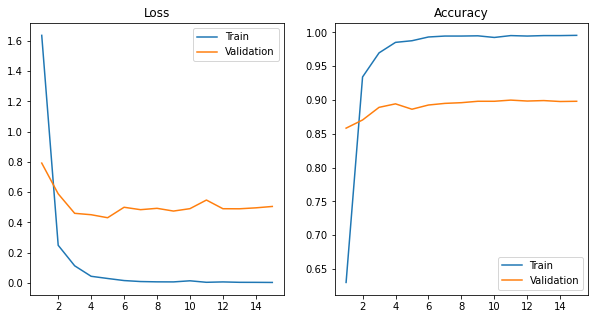


Test Accuracy: 0.905979951607328


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="vgg16")
testing(pre_net)

In [0]:
torch.cuda.empty_cache()


In [0]:
# Load the pre-trained network
pre_net = resnet50(pretrained=True)

# Freeze convolutional layers
for param in pre_net.parameters():
    param.requires_grad = False

# Add FC layer for classification
pre_net.fc= nn.Linear(2048, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.fc.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.721789360046387
Step 10, Loss 3.3796603679656982
Step 20, Loss 2.3546483516693115
Step 30, Loss 1.8511154651641846
Step 40, Loss 1.606659173965454



Validation Accuracy: 0.7520746887966805

(0.7520746887966805, tensor(1.2764, device='cuda:0'))
Starting epoch 2/15, LR = [0.01]
Step 50, Loss 1.0797715187072754
Step 60, Loss 1.0004301071166992
Step 70, Loss 0.9322711825370789
Step 80, Loss 0.7851680517196655



Validation Accuracy: 0.8696403872752421

(0.8696403872752421, tensor(0.6349, device='cuda:0'))
Starting epoch 3/15, LR = [0.01]
Step 90, Loss 0.654289722442627
Step 100, Loss 0.590258777141571
Step 110, Loss 0.4416484832763672
Step 120, Loss 0.460816890001297
Step 130, Loss 0.3144260346889496



Validation Accuracy: 0.8907330567081605

(0.8907330567081605, tensor(0.5855, device='cuda:0'))
Starting epoch 4/15, LR = [0.01]
Step 140, Loss 0.2870982587337494
Step 150, Loss 0.45370614528656006
Step 160, Loss 0.32314395904541016
Step 170, Loss 0.29485881328582764



Validation Accuracy: 0.9024896265560166

(0.9024896265560166, tensor(0.4372, device='cuda:0'))
Starting epoch 5/15, LR = [0.01]
Step 180, Loss 0.23875626921653748
Step 190, Loss 0.20346996188163757
Step 200, Loss 0.1539929211139679
Step 210, Loss 0.2641019821166992
Step 220, Loss 0.21563461422920227



Validation Accuracy: 0.9000691562932227

(0.9000691562932227, tensor(0.3880, device='cuda:0'))
Starting epoch 6/15, LR = [0.01]
Step 230, Loss 0.19522464275360107
Step 240, Loss 0.18658530712127686
Step 250, Loss 0.30026280879974365
Step 260, Loss 0.22301633656024933



Validation Accuracy: 0.9107883817427386

(0.9107883817427386, tensor(0.3211, device='cuda:0'))
Starting epoch 7/15, LR = [0.01]
Step 270, Loss 0.16628332436084747
Step 280, Loss 0.3277832567691803
Step 290, Loss 0.1126619279384613
Step 300, Loss 0.1412537693977356
Step 310, Loss 0.18659746646881104



Validation Accuracy: 0.9128630705394191

(0.9128630705394191, tensor(0.3162, device='cuda:0'))
Starting epoch 8/15, LR = [0.01]
Step 320, Loss 0.15969052910804749
Step 330, Loss 0.14175841212272644
Step 340, Loss 0.09796473383903503
Step 350, Loss 0.1866164356470108



Validation Accuracy: 0.9094052558782849

(0.9094052558782849, tensor(0.3628, device='cuda:0'))
Starting epoch 9/15, LR = [0.01]
Step 360, Loss 0.16298550367355347
Step 370, Loss 0.126698836684227
Step 380, Loss 0.11545900255441666
Step 390, Loss 0.12699876725673676
Step 400, Loss 0.1990370750427246



Validation Accuracy: 0.9142461964038727

(0.9142461964038727, tensor(0.4002, device='cuda:0'))
Starting epoch 10/15, LR = [0.01]
Step 410, Loss 0.1531837433576584
Step 420, Loss 0.1349330097436905
Step 430, Loss 0.18956907093524933
Step 440, Loss 0.09692493826150894



Validation Accuracy: 0.91701244813278

(0.91701244813278, tensor(0.3986, device='cuda:0'))
Starting epoch 11/15, LR = [0.001]
Step 450, Loss 0.12572768330574036
Step 460, Loss 0.12457610666751862
Step 470, Loss 0.1310410052537918
Step 480, Loss 0.0793650895357132
Step 490, Loss 0.05680850148200989



Validation Accuracy: 0.9183955739972337

(0.9183955739972337, tensor(0.3407, device='cuda:0'))
Starting epoch 12/15, LR = [0.001]
Step 500, Loss 0.08961082249879837
Step 510, Loss 0.09275048971176147
Step 520, Loss 0.09245064109563828
Step 530, Loss 0.13162150979042053



Validation Accuracy: 0.921161825726141

(0.921161825726141, tensor(0.3434, device='cuda:0'))
Starting epoch 13/15, LR = [0.001]
Step 540, Loss 0.13224101066589355
Step 550, Loss 0.08449401706457138
Step 560, Loss 0.08361998945474625
Step 570, Loss 0.13228687644004822
Step 580, Loss 0.13860222697257996



Validation Accuracy: 0.9197786998616874

(0.9197786998616874, tensor(0.3277, device='cuda:0'))
Starting epoch 14/15, LR = [0.001]
Step 590, Loss 0.07041183859109879
Step 600, Loss 0.09745516628026962
Step 610, Loss 0.11351921409368515
Step 620, Loss 0.08172003924846649



Validation Accuracy: 0.9180497925311203

(0.9180497925311203, tensor(0.3403, device='cuda:0'))
Starting epoch 15/15, LR = [0.001]
Step 630, Loss 0.09437356889247894
Step 640, Loss 0.08755823224782944
Step 650, Loss 0.11327659338712692
Step 660, Loss 0.09561791270971298
Step 670, Loss 0.1603856086730957



Validation Accuracy: 0.9197786998616874

(0.9197786998616874, tensor(0.3361, device='cuda:0'))


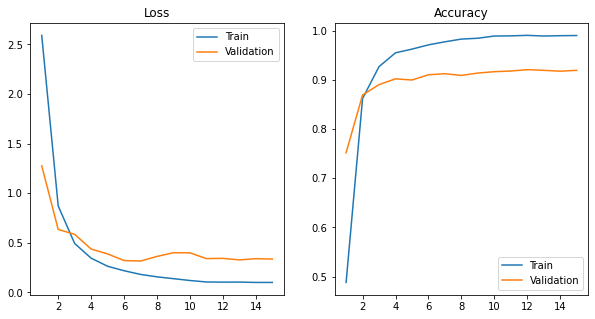


Test Accuracy: 0.917732457656412


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="ResNet50")
testing(pre_net)